In [ ]:
!pip install textstat -q
!pip install language_tool_python -q
!pip install gdown==4.6.0 -q
!pip install eli5 -q

import eli5
import spacy
import pandas as pd
import numpy as np
import csv
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.utils import shuffle
from wordcloud import WordCloud
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from textstat.textstat import textstat
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import LinearSVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')
nltk.download("wordnet")
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
!gdown 19A2fo1v2jTe3k2vQ4hWiXHdizn3KYdgw

!gdown 1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW

Downloading...
From: https://drive.google.com/uc?id=19A2fo1v2jTe3k2vQ4hWiXHdizn3KYdgw
To: /content/Chat gpt - reviews.txt
100% 212k/212k [00:00<00:00, 91.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dw3QSY4NCpbcsp6maUC06wAMk31_SzKW
To: /content/hotel_reviews.csv
100% 1.33M/1.33M [00:00<00:00, 113MB/s]


In [ ]:
reviews = []
labels = []
pos_neg_values = []

# Read the text file line by line
with open('Chat gpt - reviews.txt', 'r') as file:
    pos_neg = "pos"
    for line in file:
        line = line.strip()
        if line == "---Negative Reviews---":
            pos_neg = "neg"
            continue
        if line:
            reviews.append(line)
            labels.append(0)  # deceptive
            pos_neg_values.append(pos_neg)

# Create a DataFrame
df = pd.DataFrame({'review_text': reviews, 'label': labels, 'pos_neg': pos_neg_values})
df['generation'] = 'ChatGPT'
print(df.shape)

(400, 4)


In [ ]:
df

,review_text,label,pos_neg,generation
0,"Blu, the color of the serene sea, was the them...",0,pos,ChatGPT
1,Disabled-friendly facilities can often be a hi...,0,pos,ChatGPT
2,"Location wise, the hotel is an absolute gem, n...",0,pos,ChatGPT
3,"220 times over, I would recommend this hotel t...",0,pos,ChatGPT
4,Accommodations at the Grand Royale Hotel surpa...,0,pos,ChatGPT
...,...,...,...,...
395,"Luckily, I'm a seasoned traveler, so I've seen...",0,neg,ChatGPT
396,"Teenager-infested, this hotel negatively impac...",0,neg,ChatGPT
397,Implying that their establishment was a high-e...,0,neg,ChatGPT
398,Set in what could have been an idyllic locatio...,0,neg,ChatGPT


In [ ]:
df_hotel = pd.read_csv('hotel_reviews.csv')


# Filter real reviews with positive labels
real_positive_reviews = df_hotel[(df_hotel['label'] == 1) & (df_hotel['pos_neg'] == 'pos')]

# Filter real reviews with negative labels
real_negative_reviews = df_hotel[(df_hotel['label'] == 1) & (df_hotel['pos_neg'] == 'neg')]

# Select unique real positive reviews
unique_real_positive_reviews = real_positive_reviews[['review_text', 'label', "pos_neg"]].drop_duplicates().head(200)

# Select unique real negative reviews
unique_real_negative_reviews = real_negative_reviews[['review_text', 'label', "pos_neg"]].drop_duplicates().head(200)

# Add a "generation" column indicating that these reviews are human-generated
unique_real_positive_reviews['generation'] = 'human'
unique_real_negative_reviews['generation'] = 'human'

# Concatenate the two sets of unique reviews to get 400 real reviews
selected_reviews = pd.concat([unique_real_positive_reviews, unique_real_negative_reviews])

# Reset the index if needed
selected_reviews = selected_reviews.reset_index(drop=True)

selected_reviews

,review_text,label,pos_neg,generation
0,The sheraton was a wonderful hotel! When me an...,1,pos,human
1,took a weekend trip with my wife. got a great ...,1,pos,human
2,We stayed 6 pleasent days in this not too big ...,1,pos,human
3,I love the free breakfast and dinners on weekn...,1,pos,human
4,My wife and I redeemed some of my Hilton Rewar...,1,pos,human
...,...,...,...,...
395,I stayed in this hotel for a week and I was lo...,1,neg,human
396,Very Very noisy - Constant water running throu...,1,neg,human
397,"Firtly they took $372 off my card, even though...",1,neg,human
398,"Often visit Chicago, but this was my first sta...",1,neg,human


In [ ]:
united_df = pd.concat([df, selected_reviews], ignore_index=True)
df_shuffled = shuffle(united_df, random_state=42)

print(united_df.shape)
df_shuffled

(800, 4)


,review_text,label,pos_neg,generation
696,"Well, this used to be a Le Meridian Hotel, and...",1,neg,human
667,I haven't actually stayed at this hotel- yet- ...,1,neg,human
63,"Banking on a last-minute deal, I found myself ...",0,pos,ChatGPT
533,I read the reviews on Trip Advisor for this pr...,1,pos,human
66,"Acne, a bane of my teenage years, was the last...",0,pos,ChatGPT
...,...,...,...,...
71,Distinctly reminiscent of the ritz and glamour...,0,pos,ChatGPT
106,"Stephanie, the effervescent concierge, is the ...",0,pos,ChatGPT
270,"1-8, the rating I'd give this hotel on a scale...",0,neg,ChatGPT
435,We have just returned from a week at the James...,1,pos,human


In [ ]:
# Calculate the number of positive (pos) and negative (neg) reviews
positive_count = df_shuffled[df_shuffled['pos_neg'] == 'pos'].shape[0]
negative_count = df_shuffled[df_shuffled['pos_neg'] == 'neg'].shape[0]

# Calculate the number of rows with label 1 and label 0
label_1_count = df_shuffled[df_shuffled['label'] == 1].shape[0]
label_0_count = df_shuffled[df_shuffled['label'] == 0].shape[0]

print("Positive reviews:", positive_count)
print("Negative reviews:", negative_count)
print("Rows with label 1:", label_1_count)
print("Rows with label 0:", label_0_count)


Positive reviews: 400
Negative reviews: 400
Rows with label 1: 400
Rows with label 0: 400


# Creating the datasets

In [ ]:
y = df_shuffled["label"]
X = df_shuffled["review_text"]

In [ ]:
#train_df_70, test_df_30 = train_test_split(df_shuffled, test_size=0.3, random_state=40, stratify=df_shuffled["label"])

In [ ]:
# Extracting the target variable 'label'
#y_train = train_df_70['label']
#y_test = test_df_30['label']
#X_train = train_df_70[[ "review_text"]]
#X_test = test_df_30[["review_text"]]

(560, 1)
(560,)
(240, 1)
(240,)


# Extract features

In [ ]:
# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        # Make sure to call the super class's __init__ with all arguments.
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)

class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [self.sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)

# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)

#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

# Models & Evaluation

## Pipeline builder

In [ ]:
def build_custom_pipeline(classifier, features):
    pipeline = Pipeline([
        ('features', features),
        ('scale', StandardScaler(with_mean=False)),
        ('classifier', classifier)
    ])
    return pipeline

combined_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('tfidf_bigram', TfidfBigramVectorizer()),
    ('sentiment_score', SentimentScoreExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor()),
])

## Function for evaluation for test set and training set (if needed)

In [ ]:
def print_metrics_and_plot_confusion_matrix(classifier, X_test, y_test, model_name, labels=None):
    """
    Prints classification metrics and plots the confusion matrix for a given classifier and test data.

    :param classifier: Trained classifier (e.g., SVM classifier)
    :param X_test: Test features
    :param y_test: True labels for the test data
    :param model_name: A string with the name of the model
    :param labels: List of label names to be used in the confusion matrix and classification report
    """
    # Generate predictions
    y_pred = classifier.predict(X_test)

    # Calculate accuracy and display it
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy = {accuracy * 100:.2f}%\n")

    # Generate a classification report
    report_kwargs = {'output_dict': True}
    if labels:
        report_kwargs['target_names'] = labels
    report = classification_report(y_test, y_pred, **report_kwargs)
    report_df = pd.DataFrame(report).transpose()
    print(report_df.to_string())

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize the confusion matrix

    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)

    # Add labels in the center of the cells
    labels_text = ["True Neg", "False Pos", "False Neg", "True Pos"]
    labels_counts = ["{} ({:.2f}%)".format(value, percentage) for value, percentage in zip(cm.flatten(), (cm_normalized.flatten()*100))]
    labels_combined = [f"{text}\n{count}" for text, count in zip(labels_text, labels_counts)]

    for i in range(4):
        text_color = 'white' if cm_normalized.flatten()[i] > 0.5 else 'black'
        ax.text((i % 2) + 0.5, (i // 2) + 0.5, labels_combined[i],
                horizontalalignment='center', verticalalignment='center', color=text_color)



# Logistic Regression

In [ ]:
classifier = LogisticRegression()

# Build the pipeline using the specified classifier and features
pipeline_log = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data
#pipeline_log.fit(X_train["review_text"],y_train)


### Score on 5 fold cross validation for LR

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross validation
scores = cross_val_score(pipeline_log, X, y, cv=kfold, scoring='accuracy')

# Print the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores)}')

Cross-validation scores: [1. 1. 1. 1. 1.]
Average Score: 1.0


# Retesting with a confusion matrix because the score is too good

In [ ]:

kf = KFold(n_splits=5, shuffle=True, random_state = 42)

# Prepare to collect accuracies for each fold
fold_accuracies = []

for train_index, test_index in kf.split(X):
    X_train1, X_test1 = X.iloc[train_index], X.iloc[test_index]
    y_train1, y_test1 = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    pipeline_log.fit(X_train1, y_train1)

    # Predictions
    predictions = pipeline_log.predict(X_test1)

    # Calculate accuracy for the current fold
    fold_accuracy = accuracy_score(y_test1, predictions)
    fold_accuracies.append(fold_accuracy)

    #confusion matrix per fold
    cm = confusion_matrix(y_test1, predictions)
    print(f'Confusion matrix for fold {len(fold_accuracies)}:')
    print(cm)
    print(f'Accuracy for fold {len(fold_accuracies)}: {fold_accuracy:.4f}\n')

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average accuracy across all folds: {average_accuracy:.4f}')

Confusion matrix for fold 1:
[[80  0]
 [ 0 80]]
Accuracy for fold 1: 1.0000

Confusion matrix for fold 2:
[[83  0]
 [ 0 77]]
Accuracy for fold 2: 1.0000

Confusion matrix for fold 3:
[[78  0]
 [ 0 82]]
Accuracy for fold 3: 1.0000

Confusion matrix for fold 4:
[[80  0]
 [ 0 80]]
Accuracy for fold 4: 1.0000

Confusion matrix for fold 5:
[[79  0]
 [ 0 81]]
Accuracy for fold 5: 1.0000

Average accuracy across all folds: 1.0000


## Double checking if the results are accurate with a train and test set

Accuracy = 100.00%

              precision  recall  f1-score  support
deceptive           1.0     1.0       1.0    120.0
truthful            1.0     1.0       1.0    120.0
accuracy            1.0     1.0       1.0      1.0
macro avg           1.0     1.0       1.0    240.0
weighted avg        1.0     1.0       1.0    240.0


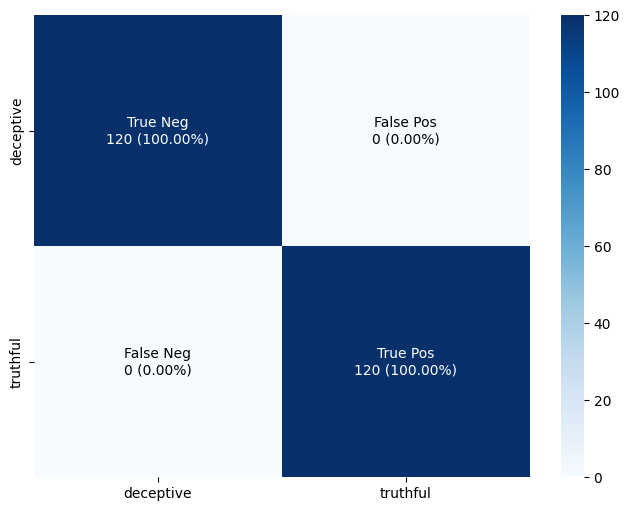

In [ ]:
print_metrics_and_plot_confusion_matrix(pipeline_log, X_test["review_text"], y_test, model_name='Logistic Regression', labels=['deceptive', 'truthful'])

# Suport Vector Machine

In [ ]:
classifier = LinearSVC(C=1.0) #max_iter=1000)
pipeline_linear_SVC = build_custom_pipeline(classifier, combined_features)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_linear_SVC, X, y, cv=kfold, scoring='accuracy')

# Print the rounded scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')

Cross-validation scores: [1. 1. 1. 1. 1.]
Average Score: 1.0000


# Confusion Matrix SVM

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

kf = KFold(n_splits=5, shuffle=True)

# Prepare to collect accuracies for each fold
fold_accuracies = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    pipeline_linear_SVC.fit(X_train, y_train)

    # Predictions
    predictions = pipeline_linear_SVC.predict(X_test)

    # Calculate accuracy for the current fold
    fold_accuracy = accuracy_score(y_test, predictions)
    fold_accuracies.append(fold_accuracy)

    # Optionally, print the confusion matrix for each fold
    cm = confusion_matrix(y_test, predictions)
    print(f'Confusion matrix for fold {len(fold_accuracies)}:')
    print(cm)
    print(f'Accuracy for fold {len(fold_accuracies)}: {fold_accuracy:.4f}\n')

# Calculate and print the average accuracy across all folds
average_accuracy = np.mean(fold_accuracies)
print(f'Average accuracy across all folds: {average_accuracy:.4f}')

Confusion matrix for fold 1:
[[71  0]
 [ 0 89]]
Accuracy for fold 1: 1.0000

Confusion matrix for fold 2:
[[82  0]
 [ 0 78]]
Accuracy for fold 2: 1.0000

Confusion matrix for fold 3:
[[78  0]
 [ 0 82]]
Accuracy for fold 3: 1.0000

Confusion matrix for fold 4:
[[83  0]
 [ 0 77]]
Accuracy for fold 4: 1.0000

Confusion matrix for fold 5:
[[86  0]
 [ 0 74]]
Accuracy for fold 5: 1.0000

Average accuracy across all folds: 1.0000


# AdaBoost

In [ ]:
sgd_hinge = SGDClassifier(loss="hinge")

pipeline_with_adaboost_samme = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', AdaBoostClassifier(
        estimator=sgd_hinge,
        n_estimators=50,
        learning_rate=1.0,
        algorithm='SAMME'
    ))
])

# Fit and use the pipelines if needed
#pipeline_with_adaboost_samme.fit(X_train["review_text"], y_train)


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_with_adaboost_samme, X, y, cv=kfold, scoring='accuracy')

# Print the rounded scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')


Cross-validation scores: [0.95625 0.96875 0.96875 0.95625 0.95   ]
Average Score: 0.9600


# Random Forest

In [ ]:
classifier = RandomForestClassifier() #(n_estimators=100)
pipeline_rdn = build_custom_pipeline(classifier, combined_features)

# Fit the pipeline on the training data - not for k fold cross
#pipeline_rdn.fit(X_train["review_text"], y_train)

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_rdn, X, y, cv=kfold, scoring='accuracy')

# Print the rounded scores and the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores):.4f}')


Cross-validation scores: [0.98125 0.9875  0.99375 0.99375 1.     ]
Average Score: 0.9912


# Feature importance LR

In [ ]:
def get_feature_names(feature_union, input_features=None):
    feature_names = []
    for transformer_name, transformer in feature_union.transformer_list:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(input_features)
        elif hasattr(transformer, 'get_feature_names'):
            names = transformer.get_feature_names()
        else:
            names = [f"{transformer_name}_{i}" for i in range(transformer.transform(X).shape[1])]
        feature_names.extend(names)
    return feature_names

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform K-Fold cross-validation
scores = cross_val_score(pipeline_log, X, y, cv=kfold, scoring='accuracy')

# Print the average score
print("Cross-validation scores:", scores)
print(f'Average Score: {np.mean(scores)}')

# Fit the model on the whole dataset for explanation purposes
pipeline_log.fit(X, y)

# Retrieve the logistic regression model from the pipeline
log_reg = pipeline_log.named_steps['classifier']

# Retrieve feature names from the pipeline (if the pipeline transforms the features)
feature_names = get_feature_names(pipeline_log.named_steps['features'])

# Use eli5 to show the feature importances
eli5.show_weights(log_reg, feature_names=feature_names)


Cross-validation scores: [1. 1. 1. 1. 1.]
Average Score: 1.0


In [ ]:
def get_feature_names(feature_union):
    feature_names = []

    for transformer_name, transformer in feature_union.transformer_list:
        if isinstance(transformer, Pipeline):
            final_transformer = transformer.steps[-1][1]
        else:
            final_transformer = transformer

        if hasattr(final_transformer, 'get_feature_names_out'):
            names = final_transformer.get_feature_names_out()
        elif hasattr(final_transformer, 'get_feature_names'):
            names = final_transformer.get_feature_names()
        else:
            try:
                num_features = final_transformer.transform(np.zeros((1, 0))).shape[1]
                names = [f"{transformer_name}_{i}" for i in range(num_features)]
            except:
                names = [transformer_name]

        feature_names.extend(names)

    return feature_names

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import spacy

# NLP model for Named Entity Recognition (NER)
nlp = spacy.load("en_core_web_sm")

def count_words_and_pos(text):
    tokens = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(tokens)

    # Define POS tags for content and function words
    content_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'JJ', 'JJR', 'JJS', 'RB', 'RBR', 'RBS'}
    function_pos = {'IN', 'PRP', 'PRP$', 'DT', 'CC', 'MD'}

    # Counters
    content_count = 0
    function_count = 0
    pos_counts = Counter()

    for word, pos in tagged:
        if pos in content_pos:
            content_count += 1
        elif pos in function_pos:
            function_count += 1
        pos_counts[pos] += 1

    return content_count, function_count, pos_counts

# Custom transformer for counting content, function words, and specific POS
class Content_Extractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        counts = [count_words_and_pos(text) for text in texts]
        content_counts, function_counts, pos_counts_list = zip(*counts)

        return np.array(content_counts).reshape(-1, 1)

class TfidfBigramVectorizer(TfidfVectorizer):
    def __init__(self, **kwargs):
        # Make sure to call the super class's __init__ with all arguments.
        super(TfidfBigramVectorizer, self).__init__(ngram_range=(2, 2), **kwargs)

class NerExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        ner_counts = []
        for doc in nlp.pipe(texts, disable=["parser"]):
            entities = [ent.label_ for ent in doc.ents]
            ner_counts.append(len(entities))
        return np.array(ner_counts).reshape(-1, 1)

class DigitCountExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, texts):
        digit_counts = [sum(c.isdigit() for c in text) for text in texts]
        return np.array(digit_counts).reshape(-1, 1)

class SentimentScoreExtractor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.sia = SentimentIntensityAnalyzer()

    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        vader_scores = [self.sia.polarity_scores(text) for text in texts]
        compound_scores = [score['compound'] for score in vader_scores]
        return np.array(compound_scores).reshape(-1, 1)

# function to count punctuation within the reviews
class PunctuationCounterExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        punctuation = ['.', ',', '!', '?', '\'', '\\', '\"', '(', ')', ';', ':']
        punctuation_counts = []
        for text in texts:
            count = sum(1 for char in text if char in punctuation)
            punctuation_counts.append(count)
        return np.array(punctuation_counts).reshape(-1, 1)

# function to count capitalized letters within the reviews
class CapitalizationExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        caps_counts = []

        for text in texts:
            caps_count = sum(1 for character in text if character.isupper())
            caps_counts.append(caps_count)

        return np.array(caps_counts).reshape(-1, 1)

#Flesch Readability Score as feature
class FleschReadabilityExtractor(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, texts):
        readability_scores = [textstat.flesch_reading_ease(text) for text in texts]
        return np.array(readability_scores).reshape(-1, 1)

# Precompute the vocabulary for the entire dataset for TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 2))
tfidf_vectorizer.fit(X)
fixed_vocabulary = tfidf_vectorizer.vocabulary_

# Define the FeatureUnion with a fixed vocabulary for TfidfVectorizer
combined_features = FeatureUnion([
    ('ner_feature', NerExtractor()),
    ('tfidf_bigram', TfidfBigramVectorizer(vocabulary=fixed_vocabulary)),
    ('sentiment_score', SentimentScoreExtractor()),
    ('punct_count', PunctuationCounterExtractor()),
    ('content_count', Content_Extractor()),
    ('flesch', FleschReadabilityExtractor()),
    ('cap_count', CapitalizationExtractor()),
])


# Create the pipeline with the Logistic Regression classifier
pipeline_log = Pipeline([
    ('features', combined_features),
    ('scale', StandardScaler(with_mean=False)),
    ('classifier', LinearSVC(C=1.0))
])

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare to collect the coefficients for each fold
fold_coefs = []

# Perform K-Fold cross-validation
for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Fit the pipeline on the training data
    pipeline_log.fit(X_train, y_train)

    # Retrieve the logistic regression model from the pipeline after fitting
    log_reg = pipeline_log.named_steps['classifier']

    # Store the coefficients for this fold
    fold_coefs.append(log_reg.coef_)

avg_coefs = np.mean(np.array(fold_coefs), axis=0)

In [ ]:
avg_coefs_flat = avg_coefs.flatten()
feature_union = pipeline_log.named_steps['features']
feature_names = get_feature_names(feature_union)

# Create a DataFrame with feature names and their average coefficients
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Average Coefficient': avg_coefs_flat
})

# Calculate the absolute value of the coefficients
feature_importances['Absolute Coefficient'] = feature_importances['Average Coefficient'].abs()

# Sort the features by the absolute values of their coefficients in descending order
top_20_features = feature_importances.sort_values(by='Absolute Coefficient', ascending=False).head(20)

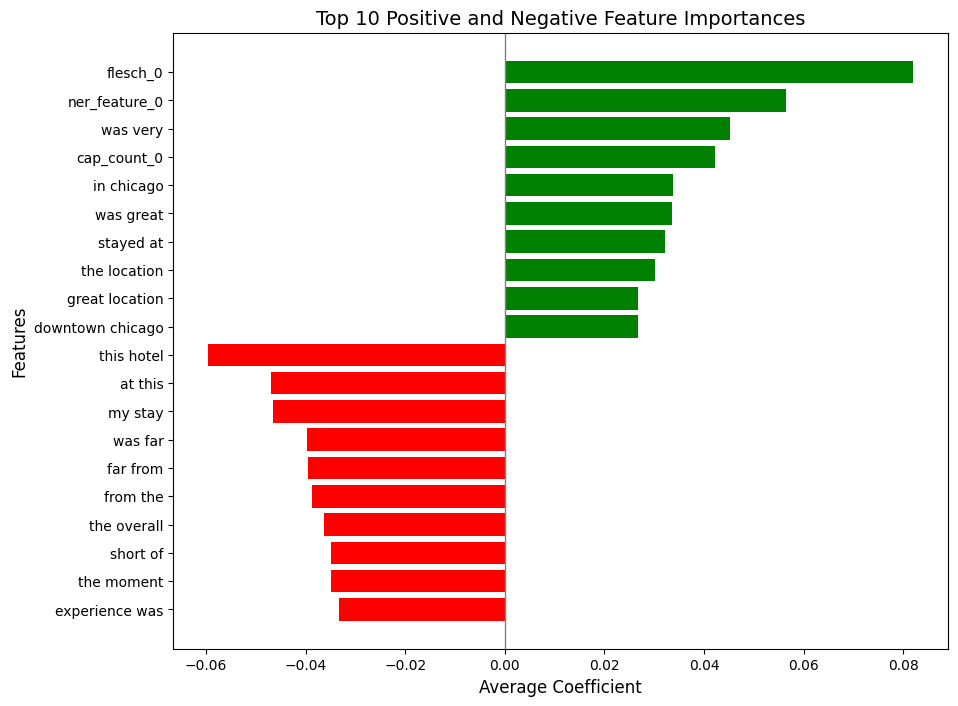

In [ ]:
# Separate the top 10 positive and top 10 negative features
top_10_positive = feature_importances[feature_importances['Average Coefficient'] > 0].sort_values(by='Average Coefficient', ascending=False).head(10)
top_10_negative = feature_importances[feature_importances['Average Coefficient'] < 0].sort_values(by='Average Coefficient').head(10)

# Concatenate the top positive and negative features
top_features = pd.concat([top_10_positive, top_10_negative])

# Create a bar plot
plt.figure(figsize=(10, 8))
colors = ['green' if x > 0 else 'red' for x in top_features['Average Coefficient']]
plt.barh(top_features['Feature'], top_features['Average Coefficient'], color=colors)
plt.xlabel('Average Coefficient', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Top 10 Positive and Negative Feature Importances', fontsize=14)
plt.axvline(x=0, color='grey', lw=1)
plt.gca().invert_yaxis()
plt.show()